In [2]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.morningstar import Fundamentals as Fundamentals_m
from quantopian.pipeline.domain import US_EQUITIES
from quantopian.research import run_pipeline
from quantopian.research import prices
import alphalens as al
from alphalens.tears import create_returns_tear_sheet
from alphalens.tears import create_information_tear_sheet
from quantopian.pipeline.data import factset
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600

In [4]:
def make_pipeline():
    
    #treasury_stock = Fundamentals_m.treasury_stock.latest # Desperate
    #treasury_stock = treasury_stock.winsorize(min_percentile=0.05, max_percentile=0.95)
    
    roa_mask = Fundamentals_m.roa.latest # Desperate
    roa_mask = roa_mask.winsorize(min_percentile=0.05, max_percentile=0.95)
    
    universe = QTradableStocksUS()
    
    combined_factor = (
        #treasury_stock
        roa_mask
        
    )

    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    long_short_screen = (longs | shorts)

    # Create pipeline
    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor
        },
        screen=long_short_screen
    )
    return pipe

Dropped 10.4% entries from factor data: 10.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.005,0.006,0.002
IC Std.,0.153,0.148,0.151
Risk-Adjusted IC,0.036,0.040,0.014
t-stat(IC),0.349,0.391,0.136
p-value(IC),0.728,0.697,0.892
IC Skew,-0.015,0.691,0.798
IC Kurtosis,-1.003,0.376,0.470


/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


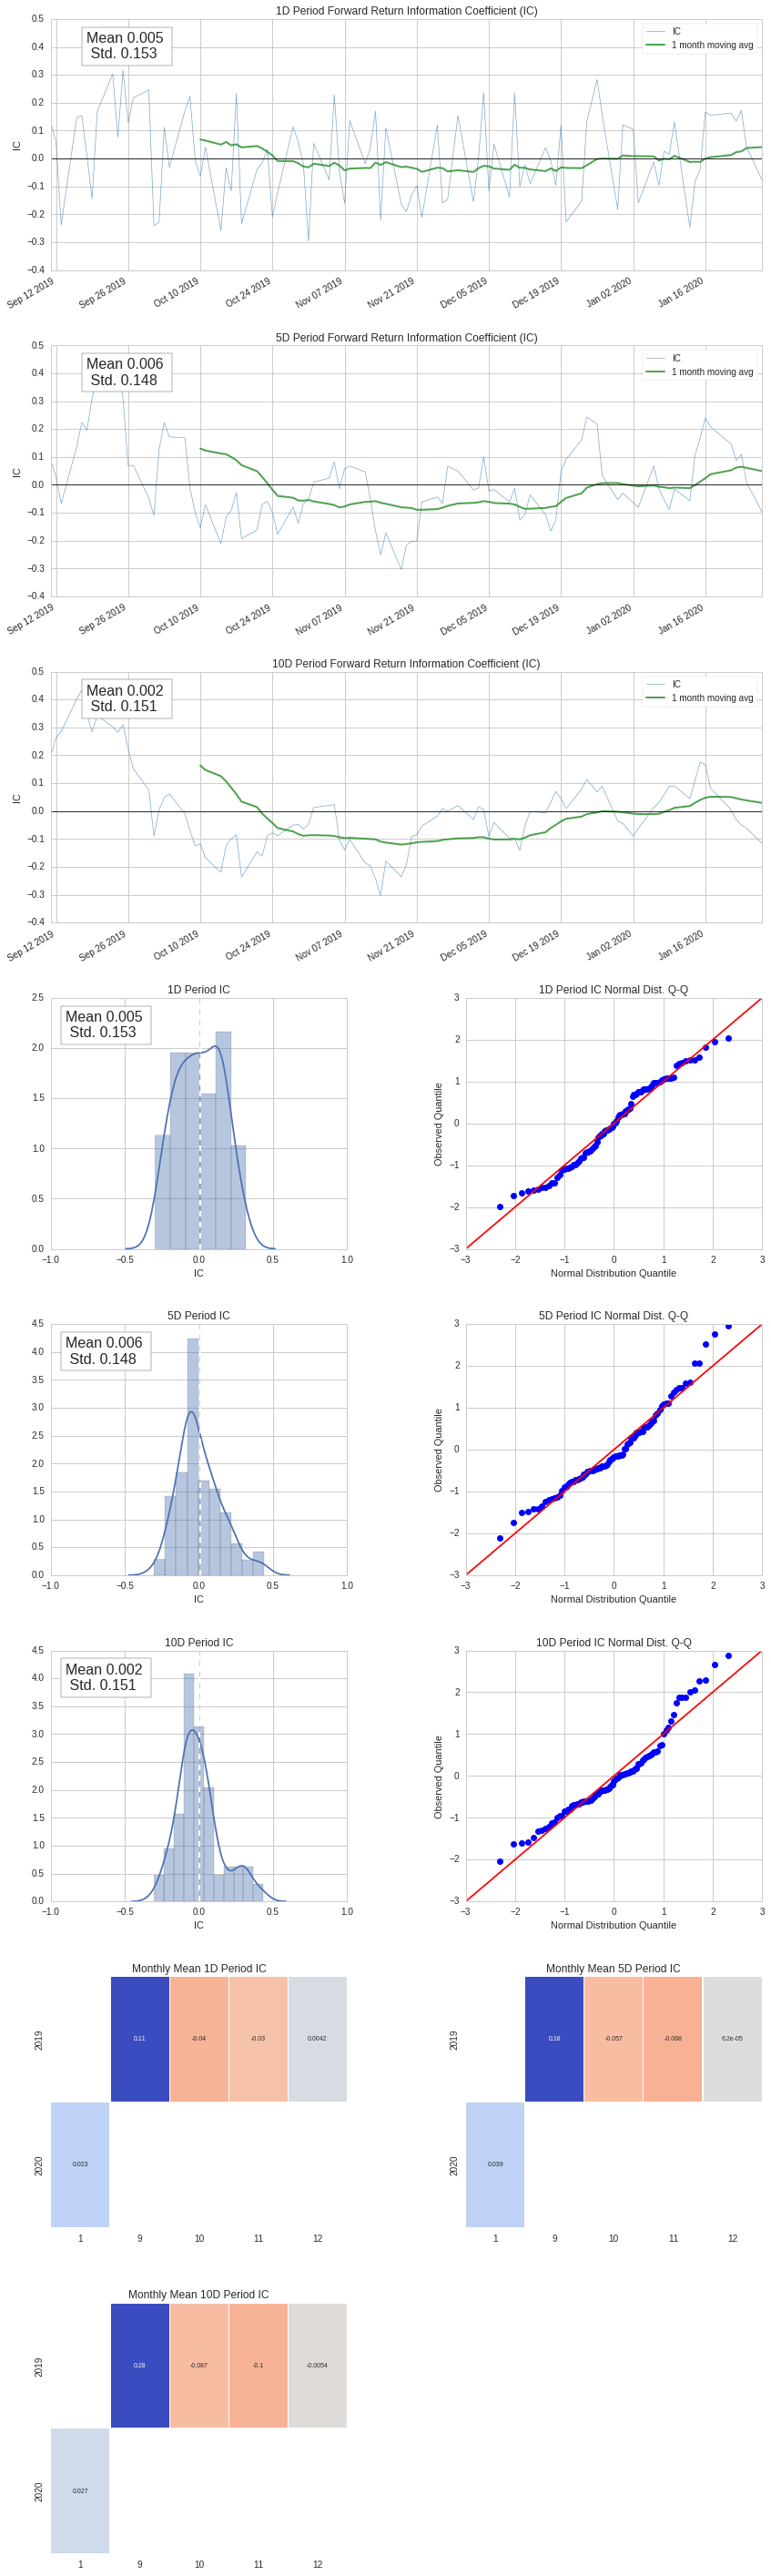

In [5]:
today = "2/11/2020"
six_months_before="9/11/2019"
two_years ="2/11/2018"

pipeline_output = run_pipeline(
    make_pipeline(),
    start_date= six_months_before,
    end_date=today
)

asset_list = pipeline_output.index.levels[1].unique()
asset_prices = prices(
    asset_list,
    start=six_months_before,
    end=today
)
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['combined_factor'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)
create_information_tear_sheet(factor_data)

Dropped 2.2% entries from factor data: 2.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.008,0.017,0.022
IC Std.,0.163,0.156,0.148
Risk-Adjusted IC,0.049,0.106,0.147
t-stat(IC),1.097,2.360,3.272
p-value(IC),0.273,0.019,0.001
IC Skew,-0.034,0.037,0.084
IC Kurtosis,-0.579,-0.184,-0.055


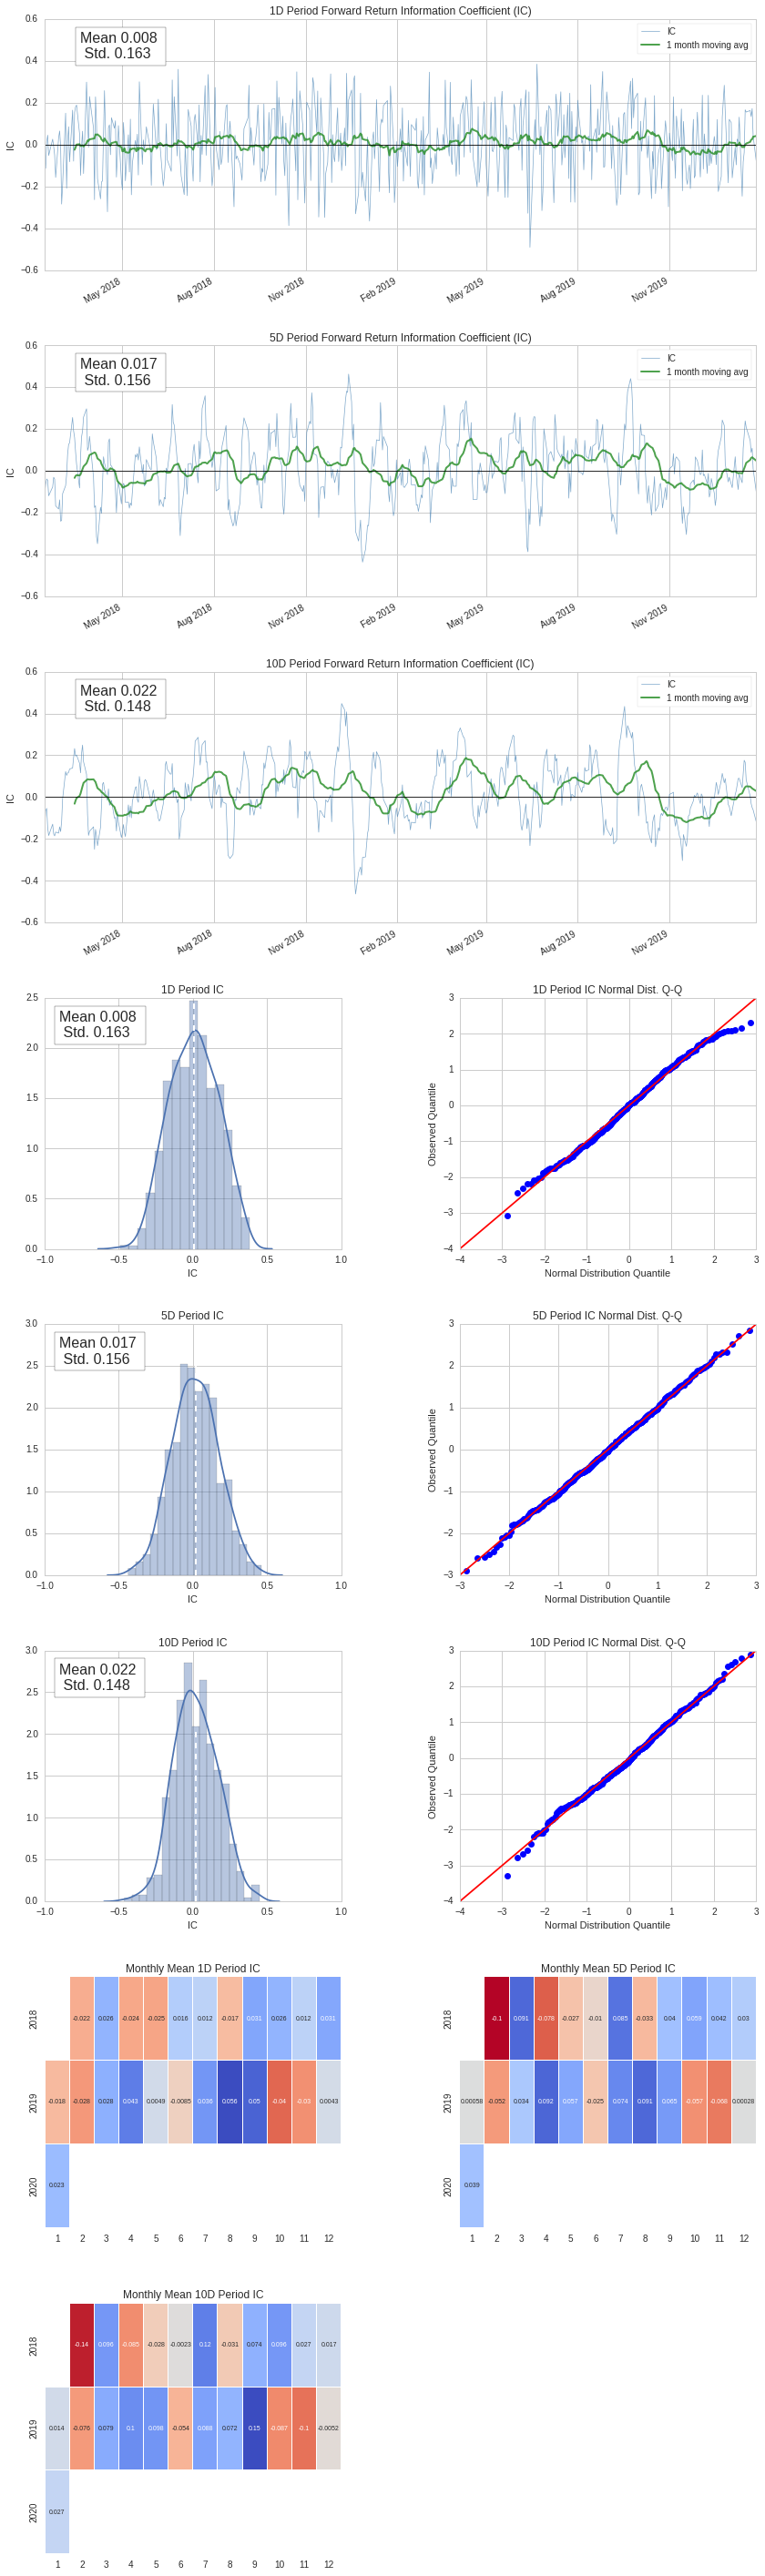

In [6]:
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date= two_years,
    end_date=today
)

asset_list = pipeline_output.index.levels[1].unique()
asset_prices = prices(
    asset_list,
    start=two_years,
    end=today
)
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['combined_factor'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)
create_information_tear_sheet(factor_data)

Returns Analysis


,1D,5D,10D
Ann. alpha,0.024,0.019,0.020
beta,-0.270,-0.292,-0.291
Mean Period Wise Return Top Quantile (bps),0.103,0.032,-0.006
Mean Period Wise Return Bottom Quantile (bps),-0.104,-0.033,0.005
Mean Period Wise Spread (bps),0.207,0.065,-0.011


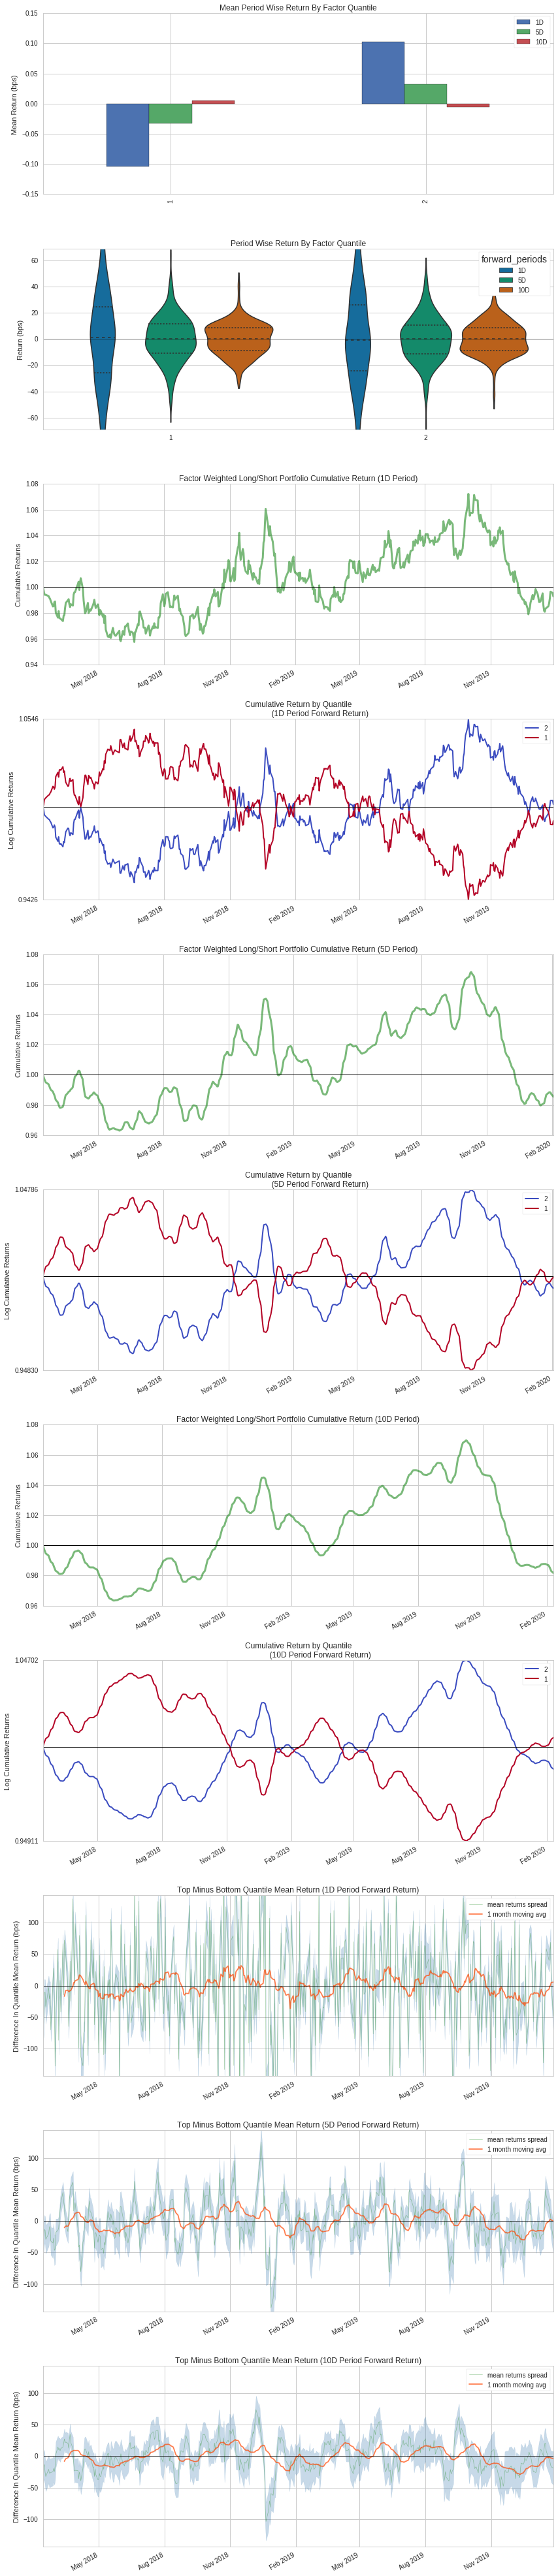

In [7]:
create_returns_tear_sheet(factor_data)